In [269]:
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD
from transformers import get_scheduler
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from datasets import Dataset

In [230]:
checkpoint = "distilbert-base-uncased"

In [231]:
batch_size = 64

# Prep training/validation data

In [33]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [34]:
# Trial data
data_train = Dataset.from_csv('data/trial.csv')
data_valid = Dataset.from_csv('data/trial.csv')

Using custom data configuration default-6cf03802fe7c5a12
Reusing dataset csv (/Users/rohanmitchell/.cache/huggingface/datasets/csv/default-6cf03802fe7c5a12/0.0.0)
Using custom data configuration default-6cf03802fe7c5a12
Reusing dataset csv (/Users/rohanmitchell/.cache/huggingface/datasets/csv/default-6cf03802fe7c5a12/0.0.0)


In [247]:
# Micro data
data_train = Dataset.from_csv('data/train-micro.csv')
data_valid = Dataset.from_csv('data/valid-micro.csv')

Using custom data configuration default-1a2309435660db1f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-82649b120c9bdc18


Dataset csv downloaded and prepared to /Users/rohanmitchell/.cache/huggingface/datasets/csv/default-1a2309435660db1f/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /Users/rohanmitchell/.cache/huggingface/datasets/csv/default-82649b120c9bdc18/0.0.0. Subsequent calls will reuse this data.


In [100]:
# Mini data
data_train = Dataset.from_csv('data/train-mini.csv')
data_valid = Dataset.from_csv('data/valid-mini.csv')

Using custom data configuration default-daa4a8e33107a876
Reusing dataset csv (/Users/rohanmitchell/.cache/huggingface/datasets/csv/default-daa4a8e33107a876/0.0.0)
Using custom data configuration default-0f73ba8ec2b92be8
Reusing dataset csv (/Users/rohanmitchell/.cache/huggingface/datasets/csv/default-0f73ba8ec2b92be8/0.0.0)


In [8]:
# Full data
data_train = Dataset.from_csv('data/train.csv')
data_valid = Dataset.from_csv('data/valid.csv')

Using custom data configuration default-16496940b3cae9e5
Reusing dataset csv (/home/.cache/huggingface/datasets/csv/default-16496940b3cae9e5/0.0.0)
Using custom data configuration default-7fec7a7bbca81e52
Reusing dataset csv (/home/.cache/huggingface/datasets/csv/default-7fec7a7bbca81e52/0.0.0)


In [248]:
def encode(sample):
    return tokenizer(sample['text'], padding=True, truncation=True)

In [249]:
data_train = data_train.map(encode, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [250]:
data_valid = data_valid.map(encode, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [251]:
data_train = data_train.remove_columns(['text'])
data_valid = data_valid.remove_columns(['text'])
data_train = data_train.rename_column('rating', 'labels')
data_valid = data_valid.rename_column('rating', 'labels')
data_train.set_format('torch')
data_valid.set_format('torch')

In [252]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    data_train,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
valid_dataloader = DataLoader(
    data_valid,
    batch_size=batch_size,
    collate_fn=data_collator
)

In [253]:
num_tokens = data_train['input_ids'].shape[1]

In [254]:
num_tokens, tokenizer.vocab_size

(512, 30522)

# Define model

In [42]:
class Lambda(nn.Module):
    """A neural network layer that applies the specified function to its inputs."""
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [43]:
def print_shape(x):
    print(x.shape)
    return x

def flatten(x):
    return x.view(x.shape[0], -1)

def squeeze(x):
    return x.squeeze()

In [44]:
class LinearModel(nn.Module):
    EMBEDDING_SIZE = 16
    HIDDEN_SIZE = 512
    
    
    def __init__(self, num_tokens, vocab_size):
        super(LinearModel, self).__init__()
        self.model = nn.Sequential(
            nn.Embedding(vocab_size, self.EMBEDDING_SIZE),
            Lambda(flatten),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(num_tokens*self.EMBEDDING_SIZE, self.HIDDEN_SIZE),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(self.HIDDEN_SIZE, self.HIDDEN_SIZE),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(self.HIDDEN_SIZE, 1),
            Lambda(squeeze),
        )
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model.to(device)
        self.loss = nn.MSELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids)
        
        loss = None
        if labels is not None:
            loss = self.loss(outputs, labels)
    
        return SequenceClassifierOutput(loss=loss, logits=outputs)

    def save(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        state = torch.load(path)
        self.model.load_state_dict(state)

In [45]:
class RegressiveTransformer(nn.Module):
    TRANSFORMER_HIDDEN_SIZE = 768
    LINEAR_HIDDEN_SIZE = 500
    
    def __init__(self, num_tokens):
        super(RegressiveTransformer, self).__init__()
        self.base_model = AutoModel.from_pretrained(checkpoint)
        self.head = nn.Sequential(
            nn.Linear(self.TRANSFORMER_HIDDEN_SIZE, self.LINEAR_HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(self.LINEAR_HIDDEN_SIZE, 1),
            Lambda(flatten),
            nn.Linear(num_tokens, 1),
            Lambda(flatten),
            Lambda(lambda x: x.squeeze())
        )
        
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.base_model.to(device)
        self.head.to(device)
        
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        outputs = self.head(outputs[0])
        
        loss = None
        if labels is not None:
            loss = self.loss(outputs, labels)
    
        return SequenceClassifierOutput(loss=loss, logits=outputs)
    
    def freeze_base(self):
        for param in self.base_model.parameters():
            param.requires_grad = False
    
    def unfreeze_base(self):
        for param in self.base_model.parameters():
            param.requires_grad = True
    
    def save(self, path):
        checkpoint = {
            'base': self.base_model.state_dict(),
            'head': self.head.state_dict(),
        }
        torch.save(checkpoint, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.base_model.load_state_dict(checkpoint['base'])
        self.head.load_state_dict(checkpoint['head'])

# Test Model

In [199]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "Left left left",
    "Right right right",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")

In [200]:
inputs

{'input_ids': tensor([[ 101, 2187, 2187, 2187,  102],
        [ 101, 2157, 2157, 2157,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])}

In [201]:
num_tokens = inputs['input_ids'].shape[1]

In [202]:
inputs['input_ids'].shape

torch.Size([2, 5])

In [209]:
tokenizer.vocab_size

30522

In [ ]:
model = RegressiveTransformer(num_tokens)

outputs = model(**inputs)
print(outputs)
print(outputs.logits.size())

In [223]:
e = nn.Embedding(3, 5)
e.forward(torch.tensor([0, 1, 2]))

tensor([[ 1.1557, -1.5389,  0.1895, -0.7843,  0.1395],
        [ 0.2366,  0.2738, -0.2696, -0.0122,  2.6147],
        [-1.9680,  0.0860, -1.3859, -1.5596,  1.6392]],
       grad_fn=<EmbeddingBackward0>)

In [227]:
len(raw_inputs), num_tokens

(2, 5)

In [243]:
model = LinearModel(num_tokens, tokenizer.vocab_size)

outputs = model(**inputs)
print(outputs)
print(outputs.logits.size())

SequenceClassifierOutput(loss=None, logits=tensor([[-0.1613],
        [-0.1300]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
torch.Size([2, 1])


# Define Trainer

In [302]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, lr=0.00001, acc_thresh=0.25):
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        #self.optimizer = AdamW(model.parameters(), lr=lr)
        self.optimizer = SGD(model.parameters(), lr=lr)
        self.acc_thresh = acc_thresh
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    def train(self, num_epochs, max_batches=None):
        num_train_batches = min(len(self.train_dataloader), max_batches or float('inf'))
        num_valid_batches = min(len(self.valid_dataloader), max_batches or float('inf'))
        num_train_steps = num_epochs * num_train_batches
        num_valid_steps = num_epochs * num_valid_batches
        self.lr_scheduler = self.__get_scheduler(num_train_steps)
        
        outputs = []
        losses = []
        accuracies = []
        means = []
        stds = []
        
        self.train_progress = tqdm(range(num_train_steps))
        self.train_progress.set_description('Training')
        self.valid_progress = tqdm(range(num_valid_steps))
        self.valid_progress.set_description('Validation')
        for epoch in range(num_epochs):
            epoch_losses = self.__train(max_batches)
            epoch_outputs, epoch_accuracies, epoch_means, epoch_stds = self.__eval(max_batches)
            outputs.extend(epoch_outputs)
            losses.append(np.mean(epoch_losses))
            accuracies.append(np.mean(epoch_accuracies))
            means.extend(epoch_means)
            stds.extend(epoch_stds)
        
        return {
            'outputs': outputs,
            'losses': losses,
            'accuracies': accuracies,
            'means': means,
            'stds': stds,
        }

    def __train(self, max_batches=None):
        losses = []
        model.train()
        for i, batch in enumerate(self.train_dataloader):
            if max_batches and i >= max_batches: break
            batch = {k: v.to(self.device) for k, v in batch.items()}
            outputs = self.model(**batch)
            loss = outputs.loss
            losses.append(loss.item())
            loss.backward()

            self.optimizer.step()
            self.lr_scheduler.step()
            self.train_progress.update(1)
        return losses

    def __eval(self, max_batches=None):
        accuracies = []
        all_outputs = []
        means = []
        stds = []
        
        model.eval()
        for i, batch in enumerate(self.valid_dataloader):
            if max_batches and i >= max_batches: break
            batch = {k: v.to(self.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.model(**batch)

            # Record outputs
            all_outputs.append(outputs.logits.squeeze().tolist())
            
            # Record accuracies
            diffs = (batch['labels'] - outputs.logits).abs()
            num_correct = torch.count_nonzero(diffs.where(diffs < self.acc_thresh, torch.zeros_like(diffs)))
            accuracies.append((num_correct / float(batch['labels'].shape[0])).cpu())
            
            # Record mean and std for each label
            d = pd.DataFrame({ 'label': batch['labels'], 'output': outputs.logits })
            means.append(d.groupby('label').mean())
            stds.append(d.groupby('label').std())
            
            self.valid_progress.update(1)
        return (all_outputs, accuracies, means, stds)

    def __get_scheduler(self, num_training_steps):
        return get_scheduler(
            "cosine",
            optimizer=self.optimizer,
            num_warmup_steps=50,
            num_training_steps=num_training_steps,
        )

# Train

In [316]:
def plot_results(results, smoothing_window=1):
    window = [1/smoothing_window] * smoothing_window
    plt.plot(np.convolve(results['losses'], window, 'valid'))
    plt.plot(np.convolve(results['accuracies'], window, 'valid'))
    plt.show()

In [49]:
def plot_outputs(results):
    plt.plot(results['outputs'])
    plt.show()

In [50]:
def build_confusion_matrix(model, dataset):
    outputs = model(dataset['input_ids'], attention_mask=None).logits.squeeze().detach()
    int_outputs = (outputs * 2).round().int().clamp(-2, 2)
    int_labels = (data_valid['labels'] * 2).int()
    return confusion_matrix(int_labels, int_outputs)

In [51]:
def plot_confusion_matrix(matrix):
    n_total = sum(sum(matrix))
    n_acc = sum([matrix[i, i] for i in range(len(matrix))])
    acc = int(n_acc / float(n_total) * 100)
    print(f"{n_acc} / {n_total} = {acc}%")
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)#, display_labels=[-2, -1, 0, 1, 2])
    disp.plot()
    plt.show()

### Transformer

In [79]:
model = RegressiveTransformer(num_tokens)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [80]:
model.freeze_base()

### Linear

In [323]:
model = LinearModel(num_tokens, tokenizer.vocab_size)

In [324]:
cms = []
all_results = []

In [325]:
# Display outputs over training
trainer = Trainer(model, train_dataloader, valid_dataloader, lr=0.000001)
results = trainer.train(500)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

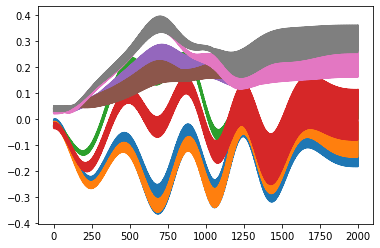

In [326]:
means = [e.output.tolist() for e in results['means']]
stds = [e.output.tolist() for e in results['stds']]
plt.plot(means)
plt.plot(stds)
plt.show()

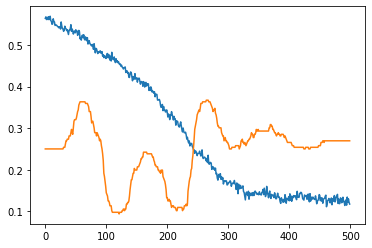

In [327]:
plot_results(results, 1)

In [328]:
max(results['accuracies']), results['accuracies'][-1], results['means'][-1], results['stds'][-1]

(0.3671875,
 0.26953125,
          output
 label          
 -1.0  -0.011401
 -0.5  -0.012951
  0.0   0.076516
  1.0   0.113738,
          output
 label          
 -1.0   0.201379
 -0.5   0.293075
  0.0   0.276281
  1.0   0.360966)

---

Trials (with micro dataset): (last acc)
- AdamW, lr=0.00001,  200 epochs -> 43% (39%)
- AdamW, lr=0.00001,  500 epochs -> 43% (24%)
- AdamW, lr=0.000001, 200 epochs -> 41% (40%)
- AdamW, lr=0.000001, 500 epochs -> 45% (35%)
- SGD,   lr=0.000001, 200 epochs -> 32% (21%)
- SGD,   lr=0.00001,  200 epochs -> 41% (16%)
- SGD,   lr=0.00001,  500 epochs -> 34% (30%)
- SGD,   lr=0.000001, 500 epochs -> 37% (30%)

I wonder if we could penalise false zeros to get it to take more risks...
Just subtract or divide by the abs output to the loss function?